In [1]:
import MetaTrader5 as mt5
import login as l
import pandas as pd
from datetime import datetime
import math
import numpy as np
import pytz
path=r"C:\Program Files\MetaTrader 5\terminal64.exe"

if mt5.initialize(path=path,login=l.login, server=l.server,password=l.password):
    print("connection established")
else :
    print("error")

connection established


In [2]:
def get_hist_data_numeric_index(symbol, timeframe, num_candles, start_pos=0):
    current_tz = pytz.timezone("Asia/Kolkata")
    hist_data = mt5.copy_rates_from_pos(symbol, getattr(mt5, timeframe), start_pos, num_candles)   
    hist_data_df = pd.DataFrame(hist_data) 

    # Convert time column to datetime
    hist_data_df.time = pd.to_datetime(hist_data_df.time, unit="s")  # Convert to naive datetime

    # Handle timezone conversion safely
    hist_data_df.time = hist_data_df.time.dt.tz_localize("EET", ambiguous=True, nonexistent='shift_forward')  # FIX DST issue
    #hist_data_df.time = hist_data_df.time.dt.tz_convert("Asia/Kolkata")  # Convert to IST
    hist_data_df.time = pd.to_datetime(hist_data_df.time)

    # Create date and time columns
    hist_data_df['date'] = hist_data_df.time.dt.strftime("%d-%m-%y")
    hist_data_df['Time1'] = pd.to_datetime(hist_data_df['time'], format="%H :%M")
    hist_data_df['Time'] = hist_data_df.time.dt.strftime("%H : %M")

    # Drop unnecessary columns
    hist_data_df.drop(['time', 'tick_volume', 'spread', 'real_volume'], axis=1, inplace=True)

    # Determine candle color
    hist_data_df['candle color'] = hist_data_df.apply(lambda row: "green" if row['close'] - row['open'] >= 0 else "red", axis=1)

    return hist_data_df


In [3]:
def add_heikin_ashi(df):
    df['HA_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # Explicitly set HA_open as float before assignment
    df['HA_open'] = 0.0  
    df.loc[0, 'HA_open'] = (df.loc[0, 'open'] + df.loc[0, 'close']) / 2

    # Compute Heikin-Ashi Open iteratively
    for i in range(1, len(df)):
        df.loc[i, 'HA_open'] = (df.loc[i-1, 'HA_open'] + df.loc[i-1, 'HA_close']) / 2

    df['HA_high'] = df[['high', 'HA_open', 'HA_close']].max(axis=1)
    df['HA_low'] = df[['low', 'HA_open', 'HA_close']].min(axis=1)

    return df

def SMA(ser, n=9):
    return ser.rolling(n).mean()

def EMA(ser, n):
    # Calculate the SMA for the first `n` values
    sma = ser.rolling(window=n).mean()
    
    # Initialize EMA array
    ema = np.full(len(ser), np.nan)
    
    # Set the initial EMA value as the first SMA value
    ema[n-1] =sma[n-1]
    
    # Multiplier for EMA
    multiplier = 2 / (n + 1)
    
    # Compute EMA for the rest of the series
    for i in range(n, len(ser)):
        ema[i] = ((ser.iloc[i] - ema[i-1]) * multiplier) + ema[i-1]
    
    return pd.Series(ema, index=ser.index)

def RMA(ser, n=9):
    # Compute the SMA for the first `n` values
    sma = ser.rolling(window=n).mean()
    
    # Initialize an array for RMA with NaN
    rma = np.full(len(ser), np.nan)
    
    # Set the initial RMA value as the first SMA value
    rma[n-1] = sma[n-1]
    
    # Calculate RMA for the rest of the series
    multiplier = 1 / n
    for i in range(n, len(ser)):
        rma[i] = ((ser.iloc[i] - rma[i-1]) * multiplier) + rma[i-1]
    
    return pd.Series(rma, index=ser.index)


def RSI(df, n=14, std_dev=2):
    df = df.copy()
    df["change"] = df["close"] - df["close"].shift(1)

    df["gain"] = np.where(df["change"] > 0, df["change"], 0)
    df["loss"] = np.where(df["change"] < 0, -df["change"], 0)

    # Use RMA (same as TradingView's calculation)
    df["avgGain"] = RMA(df["gain"], n)
    df["avgLoss"] = RMA(df["loss"], n)

    # Compute Relative Strength (RS) & RSI
    df["rs"] = np.where(df["avgLoss"] == 0, 0, df["avgGain"] / df["avgLoss"])
    df["rsi"] = 100 - (100 / (1 + df["rs"]))

    # Compute SMA of RSI
    df["sma_rsi"] = df["rsi"].rolling(window=n).mean()

    return df[["rsi","sma_rsi"]]

In [19]:
hist_data_5min= get_hist_data_numeric_index("XAUUSD", "TIMEFRAME_M5",num_candles=99000)
hist_data_1hr= get_hist_data_numeric_index("XAUUSD", "TIMEFRAME_H1",num_candles=8250)

hist_data_1hr=add_heikin_ashi(hist_data_1hr)

hist_data_1hr['blue']=EMA(hist_data_1hr['HA_close'],n=10)
hist_data_1hr['red']=EMA(hist_data_1hr['HA_close'],n=20)
hist_data_1hr = hist_data_1hr.dropna(subset=['red']).reset_index(drop=True)
#print(hist_data_1hr.to_string())

hist_data_5min[["rsi","sma_rsi"]]=RSI(hist_data_5min,n=12)
hist_data_5min = hist_data_5min.dropna(subset=['sma_rsi']).reset_index(drop=True)

#print(hist_data_5min.head())
row1=hist_data_1hr.loc[0]
starting_index=-1
for index,row in hist_data_5min.iterrows():
    if row["date"]==row1["date"] and row["Time"]==row1["Time"] :
        starting_index=index
        break
hist_data_5min=hist_data_5min.iloc[starting_index:].reset_index(drop=True)
#print(hist_data_5min.to_string())

total_trades=[]
entry={}

bottom_lvl=30
top_lvl=70
market_side=0

sum_res=0
max_res=0
min_res=100000

looking_for_entry=False
on_going_trade=False
entry_activate=False

buying_price=float("inf")

sl=10

max_drawdown=float("-inf")
max_profit=float("-inf")

for index,row in hist_data_1hr.iterrows() :
    start_time = row['Time1']
    end_time = start_time + pd.Timedelta(minutes=60)

    one_min_candle_data= hist_data_5min[
    (hist_data_5min['Time1'] >= start_time) &
    (hist_data_5min['Time1'] < end_time)
    ]
    for idx,row1 in one_min_candle_data.iterrows() :
        if market_side == 1:
            if not looking_for_entry and not on_going_trade and not entry_activate :
                if row1['rsi']<=bottom_lvl :
                    looking_for_entry=True
            elif looking_for_entry :
                if row1['rsi']>row1['sma_rsi'] :
                    looking_for_entry=False
                    entry_activate=True
                    if row1['candle color']=='green' :
                        buying_price=min(math.ceil(row1['high']*10)/10+0.2,buying_price)
            elif entry_activate :
                    if row1['high']>=buying_price :
                        entry['date']=row1['date']
                        entry['entry time']=row1['Time']
                        entry['type']="bull"
                        entry['entry price']=buying_price
                        on_going_trade=True
                        entry_activate=False
                        buying_price=float("inf")
                    else :
                        if row1['candle color']=='green' :
                            buying_price=min(math.ceil(row1['high']*10)/10+0.2,buying_price)
                        if row1['rsi']<row1['sma_rsi'] :
                            entry_activate=False
                            buying_price=float("inf")
                            looking_for_entry=True            
            if on_going_trade :
                if row1['rsi']>=top_lvl  :
                    entry['exit time']=row1['Time']
                    entry['exit price']=row1['close']
                    entry['result']=entry['exit price']-entry['entry price']
                    sum_res+=entry['result']
                    entry['profit']=sum_res
                    max_profit=max(max_profit,sum_res)
                    max_drawdown=max(max_drawdown,max_profit-sum_res)
                    max_res=max(max_res,entry['result'])
                    min_res=min(min_res,entry['result'])
                    total_trades.append(entry)
                    entry={}
                    on_going_trade=False
                elif row1['low']<=entry['entry price']-sl :
                    entry['exit time']=row1['Time']
                    entry['exit price']=entry['entry price']-sl
                    entry['result']=entry['exit price']-entry['entry price']
                    sum_res+=entry['result']
                    entry['profit']=sum_res
                    max_profit=max(max_profit,sum_res)
                    max_drawdown=max(max_drawdown,max_profit-sum_res)
                    max_res=max(max_res,entry['result'])
                    min_res=min(min_res,entry['result'])
                    total_trades.append(entry)
                    entry={}
                    on_going_trade=False
                    if row1['rsi']<=bottom_lvl :
                        looking_for_entry=True
    
    if row['blue']>row['red'] and market_side!=1 :
        market_side=1
    elif row['blue']<row['red'] and market_side!=2 :
        if on_going_trade :
            if row1['low']<=entry['entry price']-sl :
                entry['exit price']=entry['entry price']-sl
            else :
                entry['exit price']=row['close']
            entry['exit time']=None
            entry['result']=entry['exit price']-entry['entry price']
            sum_res+=entry['result']
            entry['profit']=sum_res
            max_profit=max(max_profit,sum_res)
            max_drawdown=max(max_drawdown,max_profit-sum_res)
            max_res=max(max_res,entry['result'])
            min_res=min(min_res,entry['result'])
            total_trades.append(entry)
            entry={}
            on_going_trade=False
        elif looking_for_entry :
            looking_for_entry=False
        elif entry_activate :
            entry_activate=False
        market_side=2
        buying_price=float("inf")
total_trades=pd.DataFrame(total_trades)
#print(total_trades.to_string())
#print(sum_res,max_res,min_res)
#print(entry)
#print(max_profit,max_drawdown)

In [23]:
file_path=r"D:\trades.xlsx"
total_trades.to_excel(file_path,index=True)
df = pd.read_excel(file_path)

# Save to CSV
df.to_csv("trades.csv", index=True)

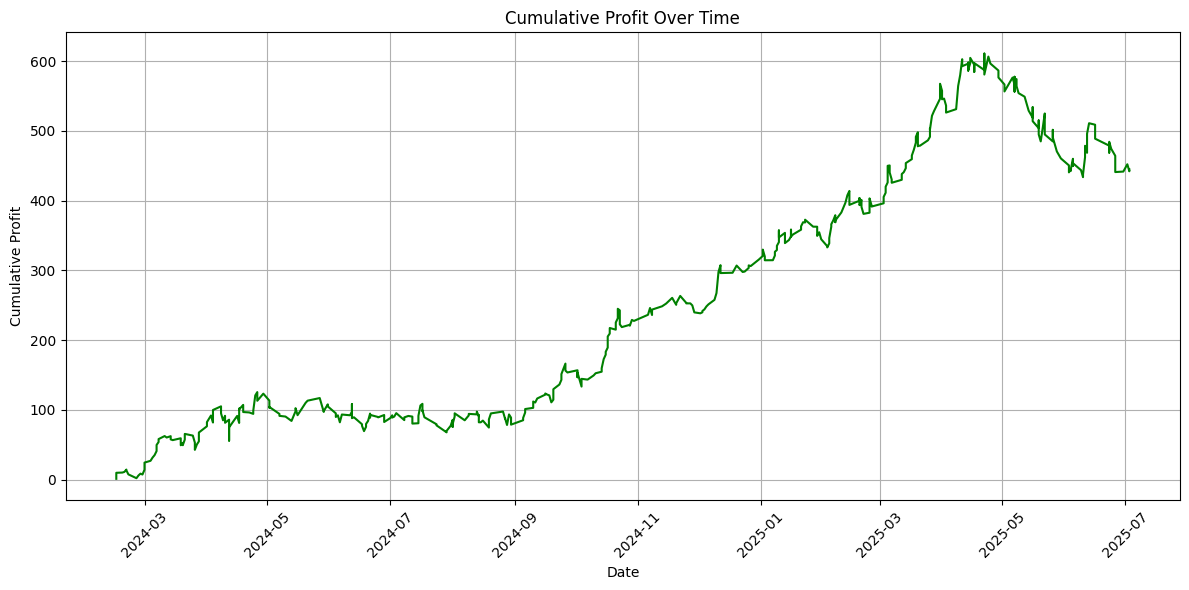

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
df = pd.read_csv(r"D:\trades.csv")

# Convert 'date' column to datetime format (if not already)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y')  # Change format if needed

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Calculate cumulative profit
df['cumulative_profit'] = df['result'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_profit'], color='green')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

trades = total_trades.copy()

rf = 0  # risk-free rate, define appropriately

win_rate = (trades['result'] > 0).sum() / len(trades) * 100
print("Win Rate:", win_rate)

avg_win = trades[trades['result'] > 0]['result'].mean()
avg_loss = abs(trades[trades['result'] < 0]['result'].mean())
rrr = avg_win / avg_loss if avg_loss != 0 else np.nan
print("Risk-Reward Ratio:", rrr)

returns = trades['result']
sharpe_ratio = (returns.mean() - rf) / returns.std() if returns.std() != 0 else np.nan
print("Sharpe Ratio:", sharpe_ratio)

negative_returns = returns[returns < rf]
downside_std = np.std(negative_returns)
sortino_ratio = (returns.mean() - rf) / downside_std if downside_std != 0 else np.nan
print("Sortino Ratio:", sortino_ratio)

# Cumulative profit
if 'profit' in trades.columns:
    cumulative_profit = trades['profit']
else:
    cumulative_profit = trades['result'].cumsum()
rolling_max = cumulative_profit.cummax()
drawdown = rolling_max - cumulative_profit
max_drawdown = drawdown.max()
print("Max Drawdown:", max_drawdown)

gross_profit = trades[trades['result'] > 0]['result'].sum()
gross_loss = abs(trades[trades['result'] < 0]['result'].sum())
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
print("Profit Factor:", profit_factor)

expectancy = trades['result'].mean()
print("Expectancy:", expectancy)

total_return = trades['result'].sum()
print("Total Return:", total_return)

num_trades = len(trades)
print("Number of Trades:", num_trades)


Win Rate: 57.6837416481069
Risk-Reward Ratio: 0.96681070469335
Sharpe Ratio: 0.1140388023494534
Sortino Ratio: 0.26326200175110415
Max Drawdown: 187.0499999999975
Profit Factor: 1.3179156448188296
Expectancy: 0.9902895322941201
Total Return: 444.6400000000599
Number of Trades: 449
